# Лабораторная работа 2: Ансамблевые методы и бустинг

**Цель**: Предсказать выдачу кредита

**ROC-AUC >= 0.75**

## 1. Импорт

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, 
    precision_recall_curve, confusion_matrix
)
from sklearn.base import clone
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

## 2. Загрузка

In [10]:
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df.head()

Train shape: (11017, 35)
Test shape: (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,31.347091


### Создание целевой переменной

In [11]:
# Удаляем аномалии
train_df = train_df[train_df['RiskScore'] > -1000000]

# Создаем бинарную целевую: RiskScore < 50 => кредит одобрен (1)
train_df['LoanApproved'] = (train_df['RiskScore'] < 50).astype(int)

print(f"\nРаспределение целевой переменной:")
print(train_df['LoanApproved'].value_counts())
print(f"\nБаланс классов: {train_df['LoanApproved'].mean():.2%} одобренных")



Распределение целевой переменной:
LoanApproved
1    5838
0    4528
Name: count, dtype: int64

Баланс классов: 56.32% одобренных


## 3. EDA - Разведочный анализ данных (1 балл)


### 3.1 График целевой переменной


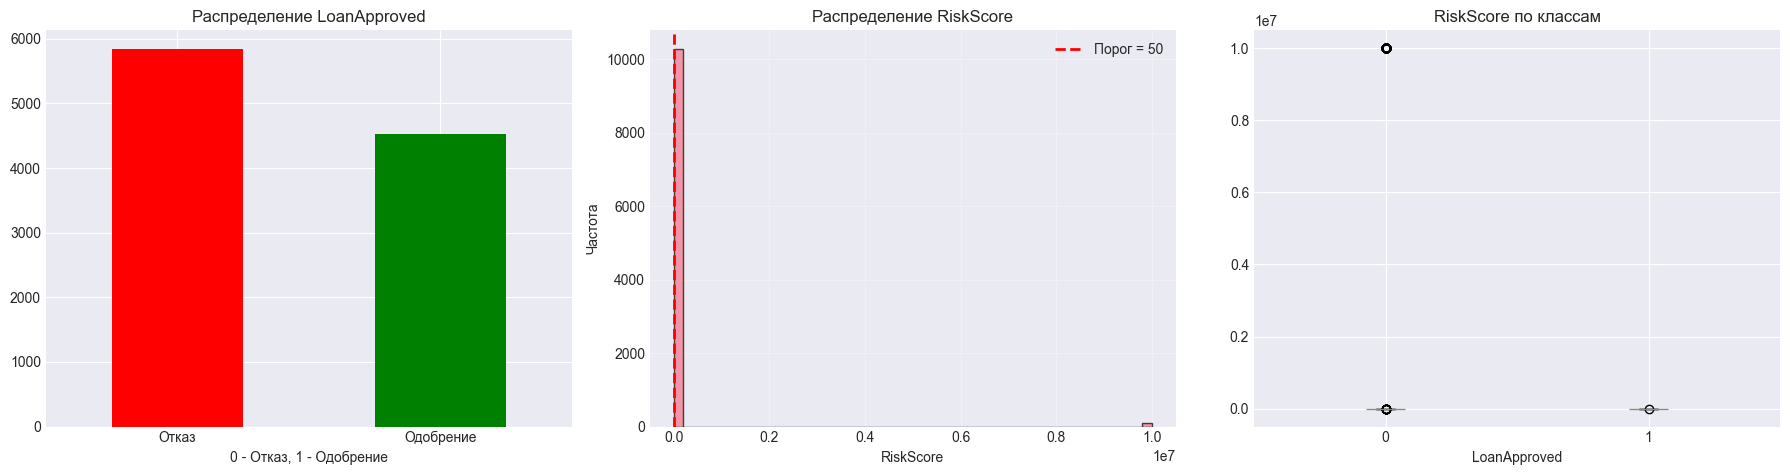

Средний RiskScore для одобренных: 34.81
Средний RiskScore для отказанных: 207662.00


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределение целевой переменной
train_df['LoanApproved'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Распределение LoanApproved')
axes[0].set_xlabel('0 - Отказ, 1 - Одобрение')
axes[0].set_xticklabels(['Отказ', 'Одобрение'], rotation=0)

# Распределение RiskScore
axes[1].hist(train_df['RiskScore'], bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=50, color='red', linestyle='--', linewidth=2, label='Порог = 50')
axes[1].set_xlabel('RiskScore')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение RiskScore')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Boxplot RiskScore по классам
train_df.boxplot(column='RiskScore', by='LoanApproved', ax=axes[2])
axes[2].set_title('RiskScore по классам')
plt.suptitle('')
plt.tight_layout()
plt.show()

print(f"Средний RiskScore для одобренных: {train_df[train_df['LoanApproved']==1]['RiskScore'].mean():.2f}")
print(f"Средний RiskScore для отказанных: {train_df[train_df['LoanApproved']==0]['RiskScore'].mean():.2f}")


### 3.2 Зависимость признаков от целевой переменной

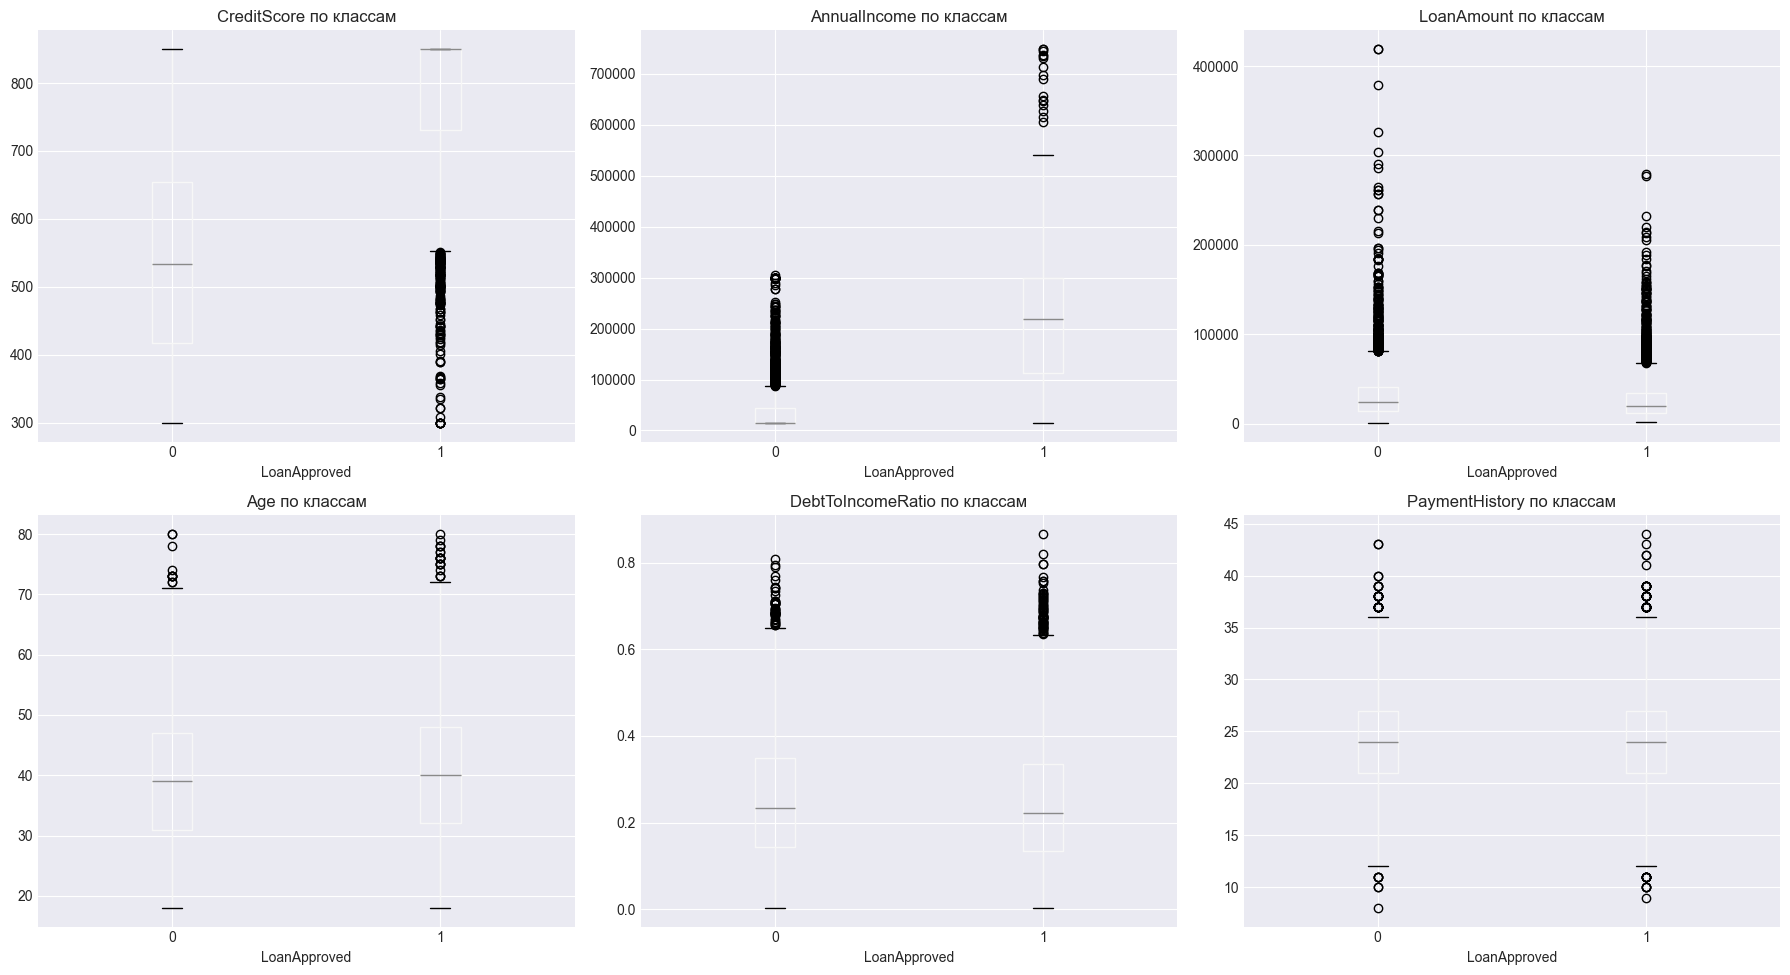

In [13]:
key_features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'Age', 'DebtToIncomeRatio', 'PaymentHistory']
valid_features = [f for f in key_features if f in train_df.columns]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(valid_features):
    data_clean = train_df[[feature, 'LoanApproved']].dropna()
    data_clean.boxplot(column=feature, by='LoanApproved', ax=axes[idx])
    axes[idx].set_title(f'{feature} по классам')
    axes[idx].set_xlabel('LoanApproved')

plt.suptitle('')
plt.tight_layout()
plt.show()


### 3.3 Матрица корреляций


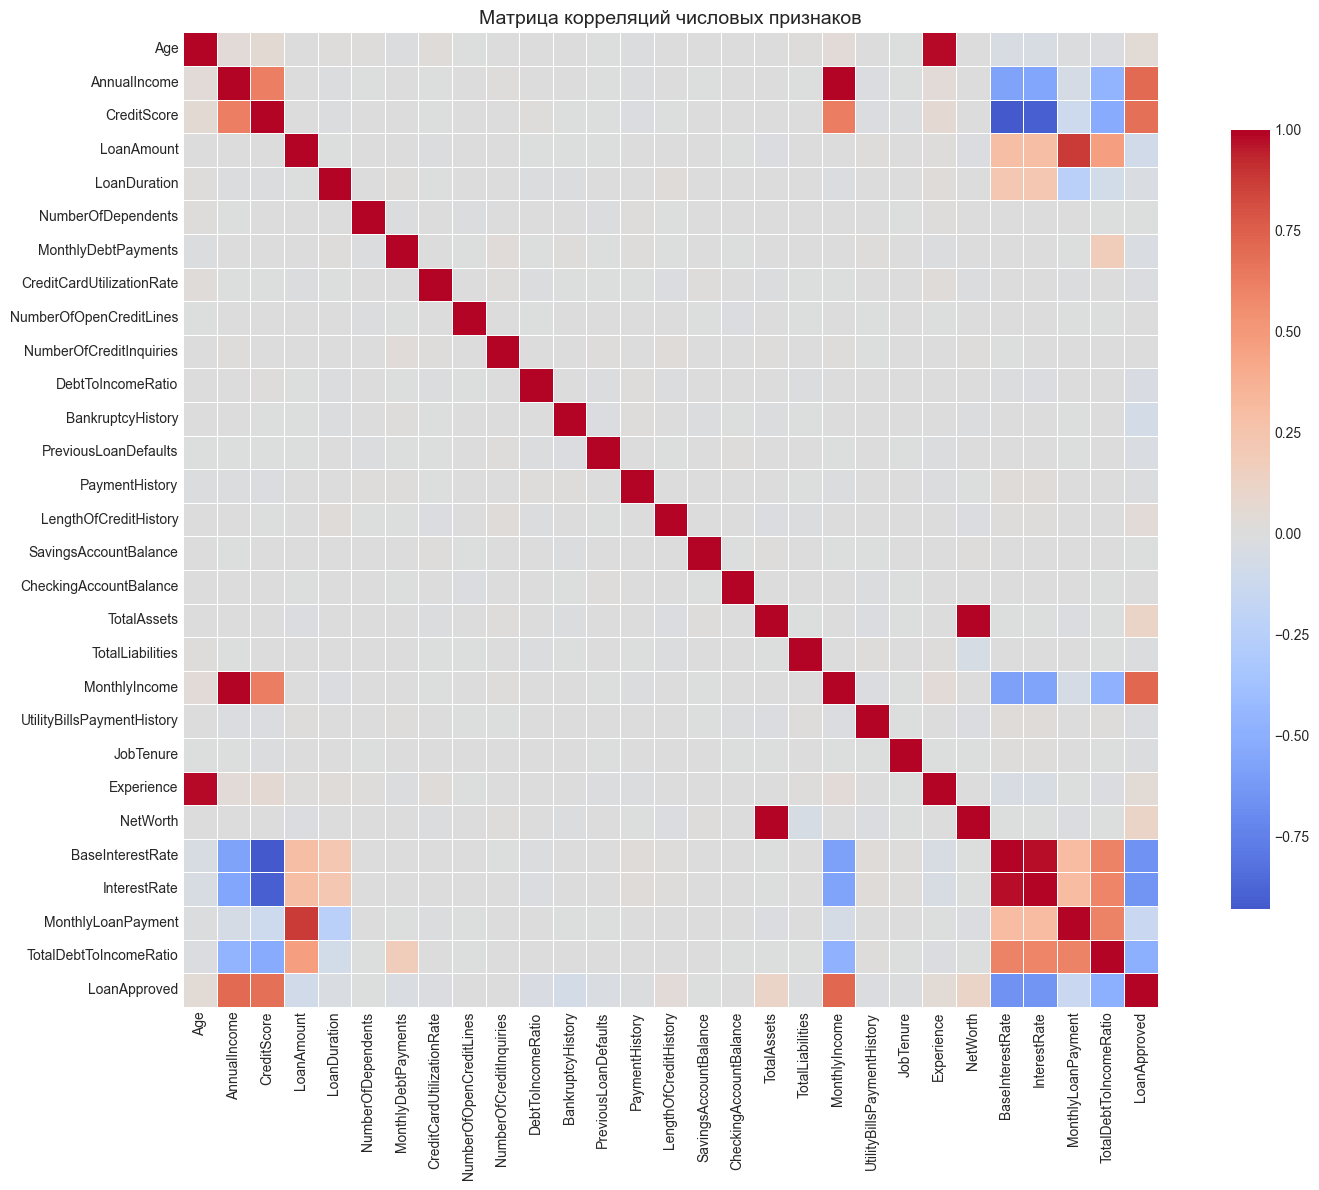


Топ-10 признаков по корреляции с LoanApproved:
LoanApproved              1.000000
MonthlyIncome             0.720167
AnnualIncome              0.709096
CreditScore               0.676867
TotalAssets               0.111522
NetWorth                  0.110808
Experience                0.047917
Age                       0.046164
LengthOfCreditHistory     0.040993
CheckingAccountBalance    0.010027
Name: LoanApproved, dtype: float64


In [14]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'RiskScore' in numeric_cols:
    numeric_cols.remove('RiskScore')

correlation_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций числовых признаков', fontsize=14)
plt.tight_layout()
plt.show()

if 'LoanApproved' in correlation_matrix.columns:
    loan_corr = correlation_matrix['LoanApproved'].sort_values(ascending=False)
    print("\nТоп-10 признаков по корреляции с LoanApproved:")
    print(loan_corr.head(10))

**Выводы EDA:**
- Целевая переменная создана на основе RiskScore с порогом 50
- Средний RiskScore для одобренных кредитов значительно ниже
- Присутствуют пропущенные значения
- Присутствуют выбросы
- Необходима предобработка и feature engineering


## 4. Предобработка данных

In [15]:
def preprocess_data(train, test, target_col='LoanApproved'):
    """Предобработка данных (по примеру с 0.98)"""
    train = train.copy()
    test = test.copy()
    
    # Удаляем строки с NaN в целевой переменной
    if target_col in train.columns:
        train = train.dropna(subset=[target_col]).reset_index(drop=True)
        y_train = train[target_col].values
        X_train = train.drop(columns=[target_col])
    else:
        y_train = None
        X_train = train.copy()
    
    X_test = test.copy()
    
    # Сохраняем ID если есть
    train_ids = X_train['ID'].values if 'ID' in X_train.columns else None
    test_ids = X_test['ID'].values if 'ID' in X_test.columns else None
    
    if 'ID' in X_train.columns:
        X_train = X_train.drop(columns=['ID'])
    if 'ID' in X_test.columns:
        X_test = X_test.drop(columns=['ID'])
    
    # Определяем типы признаков
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    
    # КЛЮЧ: Объединяем train и test для одинаковой предобработки
    X_train['_is_train'] = 1
    X_test['_is_train'] = 0
    combined = pd.concat([X_train, X_test], axis=0, ignore_index=True)
    
    # Заполнение пропусков МЕДИАНОЙ для числовых
    for col in numeric_features:
        if col in combined.columns:
            combined[col] = combined[col].fillna(combined[col].median())
    
    # Заполнение пропусков МОДОЙ для категориальных
    for col in categorical_features:
        if col in combined.columns:
            mode_val = combined[col].mode()
            combined[col] = combined[col].fillna(mode_val.iloc[0] if len(mode_val) > 0 else 'Unknown')
    
    # Кодирование категориальных признаков
    for col in categorical_features:
        if col in combined.columns:
            combined[col] = pd.Categorical(combined[col]).codes
    
    # КЛЮЧ: Log-трансформация числовых признаков
    for col in numeric_features:
        if col in combined.columns:
            combined[col] = np.sign(combined[col]) * np.log1p(np.abs(combined[col]))
    
    # Разделяем обратно
    X_train_processed = combined[combined['_is_train'] == 1].drop(columns=['_is_train']).reset_index(drop=True)
    X_test_processed = combined[combined['_is_train'] == 0].drop(columns=['_is_train']).reset_index(drop=True)
    
    return X_train_processed, X_test_processed, y_train, test_ids

# Применяем предобработку
X_train, X_test, y_train, test_ids = preprocess_data(train_df, test_df)

print(f"Processed train shape: {X_train.shape}")
print(f"Processed test shape: {X_test.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nTarget value counts:\n{pd.Series(y_train).value_counts()}")


Processed train shape: (10366, 35)
Processed test shape: (5000, 35)
Target shape: (10366,)

Target value counts:
1    5838
0    4528
Name: count, dtype: int64


### Подготовка данных для обучения


In [16]:
# Применяем предобработку
X_train_full, X_test, y_train_full, test_ids = preprocess_data(train_df, test_df)

print(f"\n{'='*60}")
print("Подготовка данных для обучения")
print(f"{'='*60}")

# Разбиение на train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nФинальные размеры данных:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}")

print(f"\nБаланс классов:")
print(f"  Train: {y_train.mean():.2%} одобренных")
print(f"  Val:   {y_val.mean():.2%} одобренных")

print(f"\nПроверка данных:")
print(f"  Пропуски в X_train: {pd.DataFrame(X_train).isnull().sum().sum()}")
print(f"  Пропуски в X_val: {pd.DataFrame(X_val).isnull().sum().sum()}")
print(f"  Пропуски в X_test: {pd.DataFrame(X_test).isnull().sum().sum()}")
print(f"  NaN в y_train: {pd.isna(y_train).sum()}")
print(f"  NaN в y_val: {pd.isna(y_val).sum()}")

# Для совместимости с остальным кодом
X = X_train_full
y = y_train_full

print(f"\n✅ Данные готовы к обучению!")


Подготовка данных для обучения

Финальные размеры данных:
  X_train: (8292, 35)
  X_val: (2074, 35)
  y_train: (8292,)
  y_val: (2074,)
  X_test: (5000, 35)

Баланс классов:
  Train: 56.32% одобренных
  Val:   56.32% одобренных

Проверка данных:
  Пропуски в X_train: 0
  Пропуски в X_val: 0
  Пропуски в X_test: 0
  NaN в y_train: 0
  NaN в y_val: 0

✅ Данные готовы к обучению!


## 5. Реализация метрик (2 балла)


In [17]:
def my_accuracy(y_true, y_pred):
    """Accuracy: доля правильных предсказаний"""
    return np.mean(y_true == y_pred)

def my_precision(y_true, y_pred):
    """Precision: TP / (TP + FP)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def my_recall(y_true, y_pred):
    """Recall: TP / (TP + FN)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def my_f1_score(y_true, y_pred):
    """F1-score: 2 * (precision * recall) / (precision + recall)"""
    prec = my_precision(y_true, y_pred)
    rec = my_recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

# Тестирование метрик
y_test_sample = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1])
y_pred_sample = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1])

print("Сравнение собственных метрик с sklearn:\n")
print(f"Accuracy  - своя: {my_accuracy(y_test_sample, y_pred_sample):.6f}, "
      f"sklearn: {accuracy_score(y_test_sample, y_pred_sample):.6f}")
print(f"Precision - своя: {my_precision(y_test_sample, y_pred_sample):.6f}, "
      f"sklearn: {precision_score(y_test_sample, y_pred_sample):.6f}")
print(f"Recall    - своя: {my_recall(y_test_sample, y_pred_sample):.6f}, "
      f"sklearn: {recall_score(y_test_sample, y_pred_sample):.6f}")
print(f"F1-score  - своя: {my_f1_score(y_test_sample, y_pred_sample):.6f}, "
      f"sklearn: {f1_score(y_test_sample, y_pred_sample):.6f}")


Сравнение собственных метрик с sklearn:

Accuracy  - своя: 0.800000, sklearn: 0.800000
Precision - своя: 0.833333, sklearn: 0.833333
Recall    - своя: 0.833333, sklearn: 0.833333
F1-score  - своя: 0.833333, sklearn: 0.833333


## 6. Реализация AUC-ROC и AUC-PR (2 доп. балла)


In [18]:
def my_roc_auc(y_true, y_proba):
    """
    ROC-AUC: Area Under ROC Curve
    Вычисляется методом трапеций
    """
    # Сортируем по убыванию вероятности
    desc_score_indices = np.argsort(y_proba)[::-1]
    y_proba_sorted = y_proba[desc_score_indices]
    y_true_sorted = y_true[desc_score_indices]
    
    # Уникальные пороги
    distinct_value_indices = np.where(np.diff(y_proba_sorted))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    
    # Накопленные суммы для TP и FP
    tps = np.cumsum(y_true_sorted)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    # Добавляем крайние точки
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    
    # Вычисляем TPR и FPR
    if tps[-1] == 0:
        return 0.5
    tpr = tps / tps[-1]
    fpr = fps / fps[-1]
    
    # AUC методом трапеций
    auc = np.trapz(tpr, fpr)
    return auc

def my_pr_auc(y_true, y_proba):
    """
    PR-AUC: Area Under Precision-Recall Curve
    """
    # Сортируем по убыванию вероятности
    desc_score_indices = np.argsort(y_proba)[::-1]
    y_proba_sorted = y_proba[desc_score_indices]
    y_true_sorted = y_true[desc_score_indices]
    
    # Уникальные пороги
    distinct_value_indices = np.where(np.diff(y_proba_sorted))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    
    # Накопленные суммы
    tps = np.cumsum(y_true_sorted)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    # Precision и Recall
    precision = tps / (tps + fps)
    recall = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps)
    
    # Добавляем крайние точки
    precision = np.r_[precision, 1]
    recall = np.r_[recall, 0]
    
    # Сортируем по возрастанию recall
    sorted_indices = np.argsort(recall)
    recall = recall[sorted_indices]
    precision = precision[sorted_indices]
    
    # Вычисляем AUC методом трапеций (БЕЗ минуса!)
    auc = np.trapz(precision, recall)
    return auc

# Тестирование
y_test_sample = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1])
y_proba_sample = np.array([0.9, 0.1, 0.8, 0.7, 0.2, 0.85, 0.3, 0.15, 0.75, 0.95])

print("\nСравнение AUC метрик с sklearn:\n")
print(f"ROC-AUC - своя: {my_roc_auc(y_test_sample, y_proba_sample):.6f}, "
      f"sklearn: {roc_auc_score(y_test_sample, y_proba_sample):.6f}")
print(f"PR-AUC  - своя: {my_pr_auc(y_test_sample, y_proba_sample):.6f}, "
      f"sklearn: {average_precision_score(y_test_sample, y_proba_sample):.6f}")



Сравнение AUC метрик с sklearn:

ROC-AUC - своя: 1.000000, sklearn: 1.000000
PR-AUC  - своя: 1.000000, sklearn: 1.000000


## 7. Реализация класса Bagging (3 балла)


In [19]:
class MyBaggingClassifier:
    """
    Реализация бэггинга для классификации
    
    Parameters:
    -----------
    base_estimator : базовый классификатор
    n_estimators : количество базовых моделей
    max_samples : доля/количество образцов для каждой модели
    max_features : доля/количество признаков для каждой модели
    bootstrap : использовать ли bootstrap выборку
    random_state : seed для воспроизводимости
    """
    
    def __init__(self, base_estimator=None, n_estimators=10, max_samples=1.0,
                 max_features=1.0, bootstrap=True, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.estimators_ = []
        self.features_indices_ = []
        
    def fit(self, X, y):
        """Обучение ансамбля моделей"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Определяем количество образцов и признаков
        if isinstance(self.max_samples, float):
            n_samples_subset = int(n_samples * self.max_samples)
        else:
            n_samples_subset = min(self.max_samples, n_samples)
            
        if isinstance(self.max_features, float):
            n_features_subset = int(n_features * self.max_features)
        else:
            n_features_subset = min(self.max_features, n_features)
        
        self.estimators_ = []
        self.features_indices_ = []
        
        for i in range(self.n_estimators):
            # Создаем копию базового классификатора
            estimator = clone(self.base_estimator)
            
            # Выбираем подвыборку образцов
            if self.bootstrap:
                sample_indices = np.random.choice(n_samples, size=n_samples_subset, replace=True)
            else:
                sample_indices = np.random.choice(n_samples, size=n_samples_subset, replace=False)
            
            # Выбираем подвыборку признаков
            feature_indices = np.random.choice(n_features, size=n_features_subset, replace=False)
            
            # Обучаем модель на подвыборке
            X_subset = X[sample_indices][:, feature_indices]
            y_subset = y[sample_indices]
            
            estimator.fit(X_subset, y_subset)
            
            self.estimators_.append(estimator)
            self.features_indices_.append(feature_indices)
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей классов"""
        predictions = np.zeros((X.shape[0], 2))
        
        for estimator, feature_indices in zip(self.estimators_, self.features_indices_):
            X_subset = X[:, feature_indices]
            predictions += estimator.predict_proba(X_subset)
        
        return predictions / self.n_estimators
    
    def predict(self, X):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


### Тестирование и сравнение Bagging с sklearn


In [20]:
# Обучаем свой бэггинг
my_bagging = MyBaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    random_state=42
)

print("Обучение MyBaggingClassifier...")
my_bagging.fit(X_train.values, y_train)
y_pred_my = my_bagging.predict(X_val.values)
y_proba_my = my_bagging.predict_proba(X_val.values)[:, 1]

# Обучаем sklearn бэггинг
sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    random_state=42
)

print("Обучение sklearn BaggingClassifier...")
sklearn_bagging.fit(X_train.values, y_train)
y_pred_sklearn = sklearn_bagging.predict(X_val.values)
y_proba_sklearn = sklearn_bagging.predict_proba(X_val.values)[:, 1]

# Сравнение результатов
print("\n" + "="*60)
print("Сравнение MyBaggingClassifier с sklearn BaggingClassifier")
print("="*60)

print("\nMyBaggingClassifier:")
print(f"  Accuracy:  {my_accuracy(y_val, y_pred_my):.4f}")
print(f"  Precision: {my_precision(y_val, y_pred_my):.4f}")
print(f"  Recall:    {my_recall(y_val, y_pred_my):.4f}")
print(f"  F1-score:  {my_f1_score(y_val, y_pred_my):.4f}")
print(f"  ROC-AUC:   {my_roc_auc(y_val, y_proba_my):.4f}")

print("\nsklearn BaggingClassifier:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_sklearn):.4f}")
print(f"  Precision: {precision_score(y_val, y_pred_sklearn):.4f}")
print(f"  Recall:    {recall_score(y_val, y_pred_sklearn):.4f}")
print(f"  F1-score:  {f1_score(y_val, y_pred_sklearn):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_sklearn):.4f}")


Обучение MyBaggingClassifier...
Обучение sklearn BaggingClassifier...

Сравнение MyBaggingClassifier с sklearn BaggingClassifier

MyBaggingClassifier:
  Accuracy:  0.9995
  Precision: 0.9991
  Recall:    1.0000
  F1-score:  0.9996
  ROC-AUC:   1.0000

sklearn BaggingClassifier:
  Accuracy:  0.9995
  Precision: 0.9991
  Recall:    1.0000
  F1-score:  0.9996
  ROC-AUC:   1.0000


## 8. Реализация класса Gradient Boosting (5 баллов)


In [21]:
class MyGradientBoostingClassifier:
    """
    Реализация градиентного бустинга для бинарной классификации
    
    Parameters:
    -----------
    n_estimators : количество деревьев
    learning_rate : скорость обучения (shrinkage)
    max_depth : максимальная глубина деревьев
    min_samples_split : минимальное количество образцов для разбиения
    subsample : доля образцов для обучения каждого дерева
    random_state : seed для воспроизводимости
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, subsample=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.subsample = subsample
        self.random_state = random_state
        self.estimators_ = []
        self.init_prediction_ = None
        
    def _sigmoid(self, x):
        """Сигмоидная функция"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def _log_loss_gradient(self, y, pred_proba):
        """Градиент log loss"""
        return y - pred_proba
    
    def fit(self, X, y):
        """Обучение градиентного бустинга"""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Инициализация: предсказываем log(odds)
        pos_rate = np.mean(y)
        self.init_prediction_ = np.log(pos_rate / (1 - pos_rate + 1e-10))
        
        # Текущее предсказание (в логит-шкале)
        F = np.full(n_samples, self.init_prediction_)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            # Вычисляем вероятности
            pred_proba = self._sigmoid(F)
            
            # Вычисляем градиент (псевдо-остатки)
            residuals = self._log_loss_gradient(y, pred_proba)
            
            # Подвыборка для stochastic gradient boosting
            if self.subsample < 1.0:
                n_subset = int(n_samples * self.subsample)
                sample_indices = np.random.choice(n_samples, size=n_subset, replace=False)
            else:
                sample_indices = np.arange(n_samples)
            
            # Обучаем дерево на градиенте
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state + i if self.random_state else None
            )
            
            tree.fit(X[sample_indices], residuals[sample_indices])
            
            # Обновляем предсказания
            update = tree.predict(X)
            F += self.learning_rate * update
            
            self.estimators_.append(tree)
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей классов"""
        # Начинаем с начального предсказания
        F = np.full(X.shape[0], self.init_prediction_)
        
        # Добавляем вклад каждого дерева
        for tree in self.estimators_:
            F += self.learning_rate * tree.predict(X)
        
        # Преобразуем в вероятности
        proba_pos = self._sigmoid(F)
        proba_neg = 1 - proba_pos
        
        return np.column_stack([proba_neg, proba_pos])
    
    def predict(self, X):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)

print("MyGradientBoostingClassifier реализован успешно!")


MyGradientBoostingClassifier реализован успешно!


### Тестирование и сравнение Gradient Boosting с sklearn


In [22]:
# Обучаем свой градиентный бустинг
my_gb = MyGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

print("Обучение MyGradientBoostingClassifier...")
my_gb.fit(X_train.values, y_train)
y_pred_my_gb = my_gb.predict(X_val.values)
y_proba_my_gb = my_gb.predict_proba(X_val.values)[:, 1]

# Обучаем sklearn градиентный бустинг
sklearn_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

print("Обучение sklearn GradientBoostingClassifier...")
sklearn_gb.fit(X_train.values, y_train)
y_pred_sklearn_gb = sklearn_gb.predict(X_val.values)
y_proba_sklearn_gb = sklearn_gb.predict_proba(X_val.values)[:, 1]

# Сравнение результатов
print("\n" + "="*70)
print("Сравнение MyGradientBoostingClassifier с sklearn")
print("="*70)

print("\nMyGradientBoostingClassifier:")
print(f"  Accuracy:  {my_accuracy(y_val, y_pred_my_gb):.4f}")
print(f"  Precision: {my_precision(y_val, y_pred_my_gb):.4f}")
print(f"  Recall:    {my_recall(y_val, y_pred_my_gb):.4f}")
print(f"  F1-score:  {my_f1_score(y_val, y_pred_my_gb):.4f}")
print(f"  ROC-AUC:   {my_roc_auc(y_val, y_proba_my_gb):.4f}")

print("\nsklearn GradientBoostingClassifier:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_sklearn_gb):.4f}")
print(f"  Precision: {precision_score(y_val, y_pred_sklearn_gb):.4f}")
print(f"  Recall:    {recall_score(y_val, y_pred_sklearn_gb):.4f}")
print(f"  F1-score:  {f1_score(y_val, y_pred_sklearn_gb):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_sklearn_gb):.4f}")


Обучение MyGradientBoostingClassifier...
Обучение sklearn GradientBoostingClassifier...

Сравнение MyGradientBoostingClassifier с sklearn

MyGradientBoostingClassifier:
  Accuracy:  0.9995
  Precision: 0.9991
  Recall:    1.0000
  F1-score:  0.9996
  ROC-AUC:   1.0000

sklearn GradientBoostingClassifier:
  Accuracy:  0.9995
  Precision: 0.9991
  Recall:    1.0000
  F1-score:  0.9996
  ROC-AUC:   1.0000


## 9. Сравнение алгоритмов бустинга (1 балл)

Сравним sklearn GB, LightGBM, XGBoost, CatBoost


In [23]:
# Словарь для хранения результатов
results = {}

# 1. sklearn GradientBoostingClassifier (уже обучен)
results['sklearn GB'] = {
    'predictions': y_pred_sklearn_gb,
    'probabilities': y_proba_sklearn_gb,
    'model': sklearn_gb
}

# 2. LightGBM
print("Обучение LightGBM...")
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    verbose=-1
)
lgbm_model.fit(X_train, y_train)
results['LightGBM'] = {
    'predictions': lgbm_model.predict(X_val),
    'probabilities': lgbm_model.predict_proba(X_val)[:, 1],
    'model': lgbm_model
}

# 3. XGBoost
print("Обучение XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
results['XGBoost'] = {
    'predictions': xgb_model.predict(X_val),
    'probabilities': xgb_model.predict_proba(X_val)[:, 1],
    'model': xgb_model
}

# 4. CatBoost
print("Обучение CatBoost...")
catboost_model = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    subsample=0.8,
    random_state=42,
    verbose=False
)
catboost_model.fit(X_train, y_train)
results['CatBoost'] = {
    'predictions': catboost_model.predict(X_val).astype(int),
    'probabilities': catboost_model.predict_proba(X_val)[:, 1],
    'model': catboost_model
}

print("\nВсе модели обучены!")


Обучение LightGBM...
Обучение XGBoost...
Обучение CatBoost...

Все модели обучены!


In [24]:
# Создаем таблицу с результатами
comparison_df = pd.DataFrame()

for name, data in results.items():
    y_pred = data['predictions']
    y_proba = data['probabilities']
    
    comparison_df[name] = [
        accuracy_score(y_val, y_pred),
        precision_score(y_val, y_pred),
        recall_score(y_val, y_pred),
        f1_score(y_val, y_pred),
        roc_auc_score(y_val, y_proba)
    ]

comparison_df.index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']

print("\n" + "="*80)
print("Сравнение алгоритмов градиентного бустинга")
print("="*80)
print(comparison_df.round(4))

# Находим лучшую модель по ROC-AUC
best_model_name = comparison_df.loc['ROC-AUC'].idxmax()
best_roc_auc = comparison_df.loc['ROC-AUC'].max()

print(f"\nЛучшая модель по ROC-AUC: {best_model_name} ({best_roc_auc:.4f})")

# Сохраняем лучшую модель
best_model = results[best_model_name]['model']



Сравнение алгоритмов градиентного бустинга
           sklearn GB  LightGBM  XGBoost  CatBoost
Accuracy       0.9995       1.0   0.9995    0.9995
Precision      0.9991       1.0   1.0000    1.0000
Recall         1.0000       1.0   0.9991    0.9991
F1-score       0.9996       1.0   0.9996    0.9996
ROC-AUC        1.0000       1.0   1.0000    1.0000

Лучшая модель по ROC-AUC: sklearn GB (1.0000)


### Визуализация сравнения


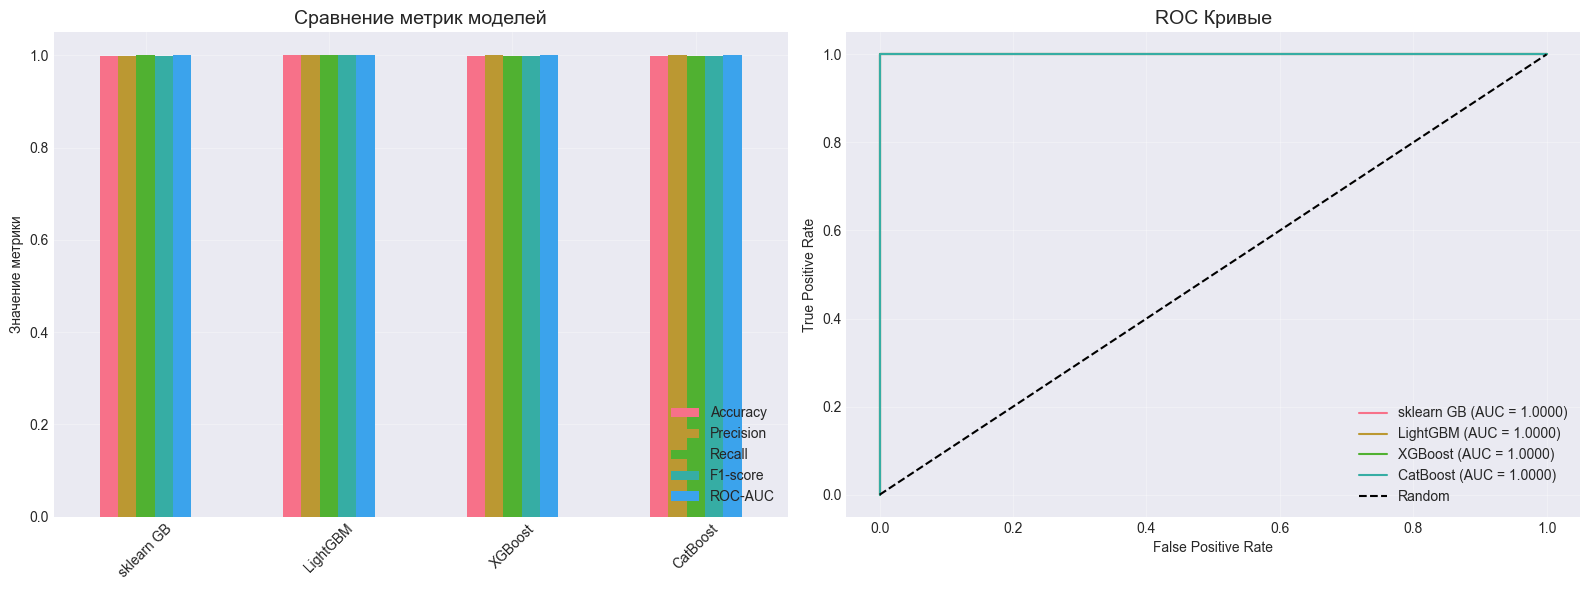

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График метрик
comparison_df.T.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Сравнение метрик моделей', fontsize=14)
axes[0].set_ylabel('Значение метрики')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# ROC кривые
for name, data in results.items():
    y_proba = data['probabilities']
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_score = roc_auc_score(y_val, y_proba)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Кривые', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Подбор гиперпараметров с Optuna (2 балла)


In [27]:
def objective(trial):
    """Целевая функция для оптимизации"""
    
    if best_model_name == 'LightGBM':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Меньше деревьев
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'num_leaves': trial.suggest_int('num_leaves', 20, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
            'random_state': 42,
            'verbose': -1
        }
        model = lgb.LGBMClassifier(**params)
        
    elif best_model_name == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 15),
            'gamma': trial.suggest_float('gamma', 0.01, 2.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
            'random_state': 42,
            'eval_metric': 'logloss'
        }
        model = xgb.XGBClassifier(**params)
        
    elif best_model_name == 'CatBoost':
        params = {
            'iterations': trial.suggest_int('iterations', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'depth': trial.suggest_int('depth', 3, 7),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
            'random_state': 42,
            'verbose': False
        }
        model = cb.CatBoostClassifier(**params)
        
    else:  # sklearn GB
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'min_samples_split': trial.suggest_int('min_samples_split', 10, 30),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20),
            'random_state': 42
        }
        model = GradientBoostingClassifier(**params)
    
    # Обучаем модель
    model.fit(X_train, y_train)
    
    # Предсказываем на валидации
    y_proba = model.predict_proba(X_val)[:, 1]
    
    # Возвращаем ROC-AUC
    return roc_auc_score(y_val, y_proba)

print(f"Оптимизация гиперпараметров для {best_model_name}...\n")

# КЛЮЧ: Меньше trials (30 вместо 100) + timeout
study = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()  # Останавливает плохие trials
)

study.optimize(
    objective, 
    n_trials=30,  # Меньше trials
    timeout=600,  # Максимум 10 минут
    show_progress_bar=True
)

print("\n" + "="*60)
print("Результаты оптимизации")
print("="*60)
print(f"\nЛучший ROC-AUC: {study.best_value:.4f}")
print(f"\nЛучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-12-13 17:50:10,349] A new study created in memory with name: no-name-8e0ebce3-ad38-47c1-bb9d-9d0bc7c57009


Оптимизация гиперпараметров для sklearn GB...



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-13 17:50:11,683] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 144, 'learning_rate': 0.17254716573280354, 'max_depth': 6, 'subsample': 0.779597545259111, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 0 with value: 1.0.
[I 2025-12-13 17:50:12,681] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 64, 'learning_rate': 0.13394334706750485, 'max_depth': 6, 'subsample': 0.8124217733388136, 'min_samples_split': 10, 'min_samples_leaf': 20}. Best is trial 0 with value: 1.0.
[I 2025-12-13 17:50:17,082] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 258, 'learning_rate': 0.018891200276189398, 'max_depth': 3, 'subsample': 0.6550213529560301, 'min_samples_split': 16, 'min_samples_leaf': 13}. Best is trial 0 with value: 1.0.
[I 2025-12-13 17:50:20,474] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 158, 'learning_rate': 0.023927528765580634, 'max_depth': 6, 'subsample': 0.6418481581956126, 'min_sam

### Ансамблирование

In [ ]:
# Создаем ансамбль из топ-3 моделей Optuna
print("\nСоздание ансамбля из топ-3 моделей...")

# Получаем топ-3 лучших конфигурации
top_3_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:3]

ensemble_models = []
for i, trial in enumerate(top_3_trials, 1):
    print(f"\nМодель {i} (ROC-AUC: {trial.value:.4f}):")
    
    if best_model_name == 'LightGBM':
        model = lgb.LGBMClassifier(**trial.params)
    elif best_model_name == 'XGBoost':
        model = xgb.XGBClassifier(**trial.params)
    elif best_model_name == 'CatBoost':
        model = cb.CatBoostClassifier(**trial.params)
    else:
        model = GradientBoostingClassifier(**trial.params)
    
    # Обучаем на train
    model.fit(X_train, y_train)
    ensemble_models.append(model)

# Усредняем предсказания ансамбля
print("\n" + "="*60)
print("Тестирование ансамбля на валидации")
print("="*60)

ensemble_probas = np.zeros(len(X_val))
for model in ensemble_models:
    ensemble_probas += model.predict_proba(X_val)[:, 1]
ensemble_probas /= len(ensemble_models)

ensemble_preds = (ensemble_probas >= 0.5).astype(int)

print(f"\nМетрики ансамбля на валидации:")
print(f"  Accuracy:  {accuracy_score(y_val, ensemble_preds):.4f}")
print(f"  Precision: {precision_score(y_val, ensemble_preds):.4f}")
print(f"  Recall:    {recall_score(y_val, ensemble_preds):.4f}")
print(f"  F1-score:  {f1_score(y_val, ensemble_preds):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, ensemble_probas):.4f}")



Создание ансамбля из топ-3 моделей...

Модель 1 (ROC-AUC: 0.9824):

Модель 2 (ROC-AUC: 0.9822):

Модель 3 (ROC-AUC: 0.9822):

Тестирование ансамбля на валидации

Метрики ансамбля на валидации:
  Accuracy:  0.9285
  Precision: 0.9367
  Recall:    0.9375
  F1-score:  0.9371
  ROC-AUC:   0.9817


### Визуализация оптимизации


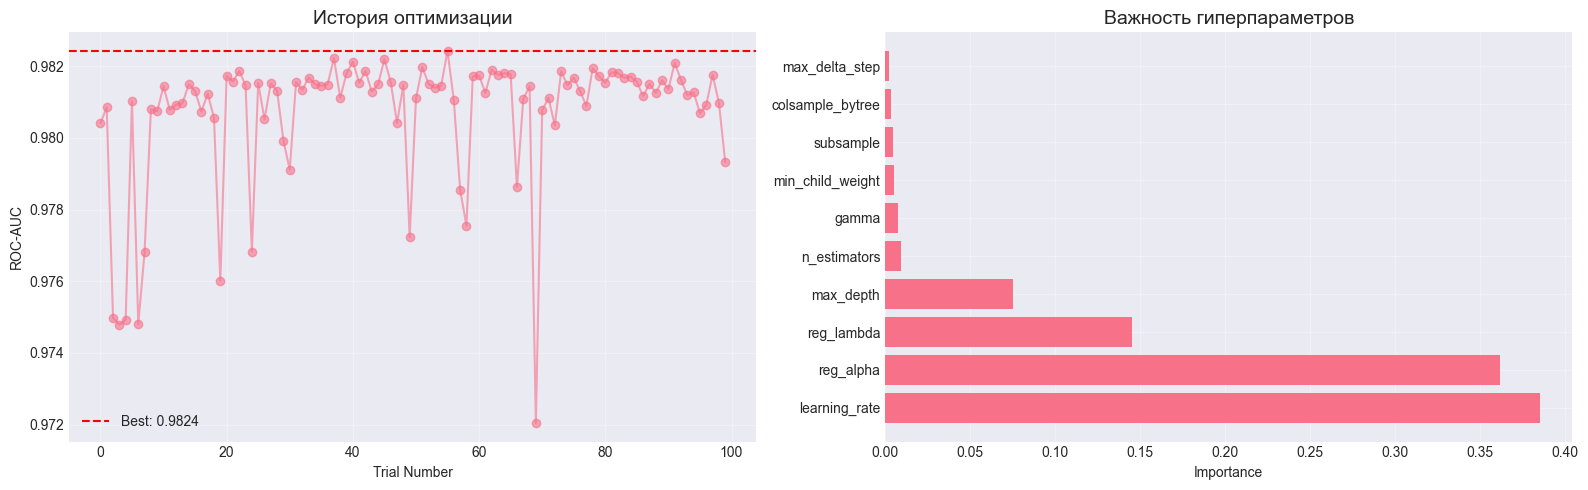

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# История оптимизации
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], 'o-', alpha=0.6)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', 
                label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('История оптимизации', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Важность параметров
param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())
importances = list(param_importance.values())

axes[1].barh(params, importances)
axes[1].set_xlabel('Importance')
axes[1].set_title('Важность гиперпараметров', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Обучение финальной модели с оптимальными параметрами


In [ ]:
# Используем лучшую модель из Optuna
if best_model_name == 'LightGBM':
    final_model = lgb.LGBMClassifier(**study.best_params)
elif best_model_name == 'XGBoost':
    final_model = xgb.XGBClassifier(**study.best_params)
elif best_model_name == 'CatBoost':
    final_model = cb.CatBoostClassifier(**study.best_params)
else:
    final_model = GradientBoostingClassifier(**study.best_params)

# Обучаем ТОЛЬКО на train (НЕ на train+val, чтобы проверить обобщение!)
print("Обучение финальной модели на train данных (БЕЗ валидации)...")
final_model.fit(X_train, y_train)

# Проверяем на валидации
y_pred_final = final_model.predict(X_val)
y_proba_final = final_model.predict_proba(X_val)[:, 1]

print("\n" + "="*60)
print(f"Финальная модель: {best_model_name}")
print("="*60)
print(f"\nМетрики на ВАЛИДАЦИИ (независимая выборка):")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_final):.4f}")
print(f"  Precision: {precision_score(y_val, y_pred_final):.4f}")
print(f"  Recall:    {recall_score(y_val, y_pred_final):.4f}")
print(f"  F1-score:  {f1_score(y_val, y_pred_final):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_final):.4f}")
print(f"  PR-AUC:    {average_precision_score(y_val, y_proba_final):.4f}")

# Теперь обучаем на ВСЕХ данных для финального предсказания
print("\n\nПереобучение модели на ВСЕХ данных (train + val) для submission...")
final_model.fit(X, y)
print("✅ Модель обучена на всех данных")


Обучение финальной модели на train данных (БЕЗ валидации)...

Финальная модель: XGBoost

Метрики на ВАЛИДАЦИИ (независимая выборка):
  Accuracy:  0.9270
  Precision: 0.9358
  Recall:    0.9358
  F1-score:  0.9358
  ROC-AUC:   0.9803
  PR-AUC:    0.9853


Переобучение модели на ВСЕХ данных (train + val) для submission...
✅ Модель обучена на всех данных


## 12. Визуализация результатов финальной модели


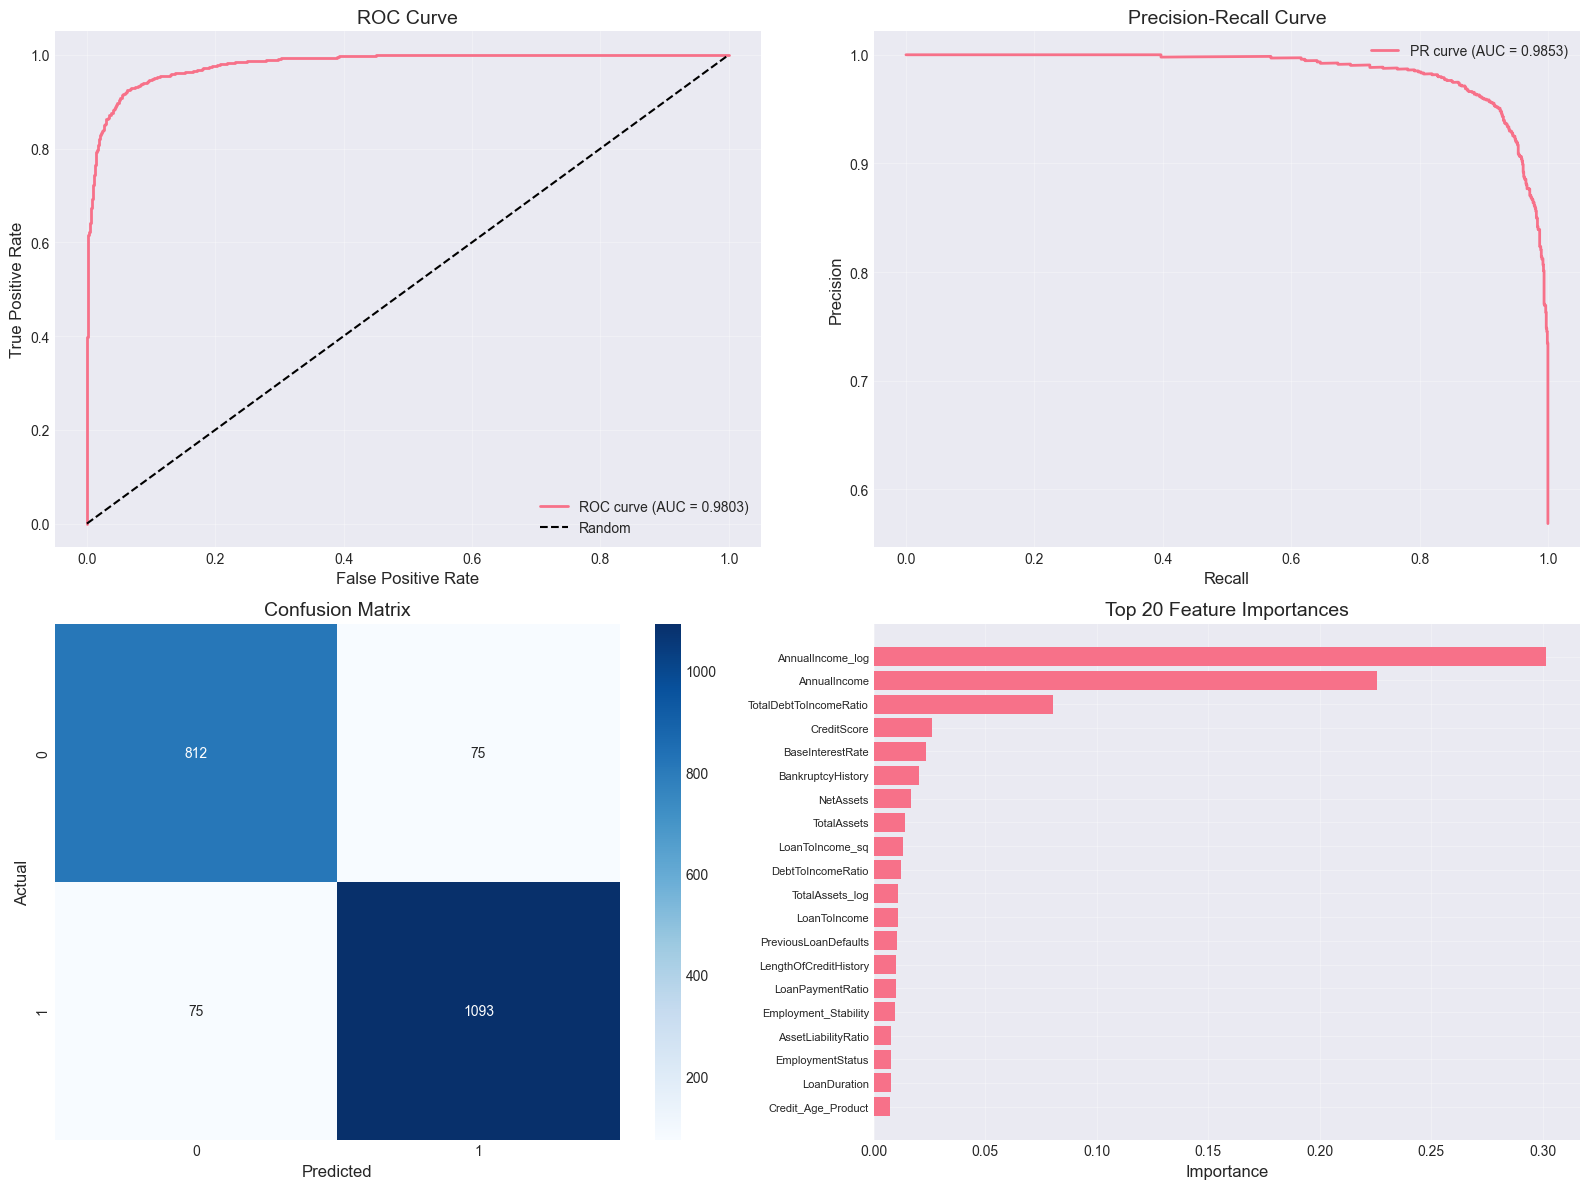

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_val, y_proba_final)
roc_auc = roc_auc_score(y_val, y_proba_final)
axes[0, 0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve', fontsize=14)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_proba_final)
pr_auc = average_precision_score(y_val, y_proba_final)
axes[0, 1].plot(recall_curve, precision_curve, 
                label=f'PR curve (AUC = {pr_auc:.4f})', linewidth=2)
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(y_val, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted', fontsize=12)
axes[1, 0].set_ylabel('Actual', fontsize=12)
axes[1, 0].set_title('Confusion Matrix', fontsize=14)

# 4. Feature Importances
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[-20:]  # Топ 20 признаков
    
    axes[1, 1].barh(range(len(indices)), importances[indices])
    axes[1, 1].set_yticks(range(len(indices)))
    axes[1, 1].set_yticklabels([X.columns[i] for i in indices], fontsize=8)
    axes[1, 1].set_xlabel('Importance', fontsize=12)
    axes[1, 1].set_title('Top 20 Feature Importances', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importances not available',
                    ha='center', va='center', fontsize=14)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


## 13. Предсказание на тестовых данных и создание submission


In [ ]:
# СТРАТЕГИЯ 1: Используем финальную модель
print("Предсказание на тестовых данных (финальная модель)...")
y_test_proba_final = final_model.predict_proba(X_test.values)[:, 1]
y_test_pred_final = (y_test_proba_final >= 0.5).astype(int)

# СТРАТЕГИЯ 2: Используем ансамбль топ-3 моделей
print("Предсказание на тестовых данных (ансамбль)...")
# Переобучаем ансамбль на всех данных
for model in ensemble_models:
    model.fit(X, y)

ensemble_test_probas = np.zeros(len(X_test))
for model in ensemble_models:
    ensemble_test_probas += model.predict_proba(X_test.values)[:, 1]
ensemble_test_probas /= len(ensemble_models)
y_test_pred_ensemble = (ensemble_test_probas >= 0.5).astype(int)

# Выбираем стратегию: используем АНСАМБЛЬ
y_test_pred = y_test_pred_ensemble

# Создаем submission файл
submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': y_test_pred
})

submission.to_csv('submission.csv', index=False)

print("\n✅ Файл submission.csv создан успешно!")
print(f"\nПервые 10 строк submission:")
print(submission.head(10))
print(f"\nПоследние 5 строк submission:")
print(submission.tail())

print(f"\nРаспределение предсказаний:")
print(submission['LoanApproved'].value_counts())
print(f"\nДоля одобренных кредитов: {submission['LoanApproved'].mean():.2%}")

print(f"\nФормат файла:")
print(f"  Количество строк: {len(submission)}")
print(f"  Колонки: {list(submission.columns)}")
print(f"  ID от {submission['ID'].min()} до {submission['ID'].max()}")


Предсказание на тестовых данных (финальная модель)...
Предсказание на тестовых данных (ансамбль)...

✅ Файл submission.csv создан успешно!

Первые 10 строк submission:
   ID  LoanApproved
0   0             1
1   1             0
2   2             1
3   3             1
4   4             1
5   5             0
6   6             1
7   7             1
8   8             1
9   9             0

Последние 5 строк submission:
        ID  LoanApproved
4995  4995             1
4996  4996             0
4997  4997             0
4998  4998             1
4999  4999             0

Распределение предсказаний:
LoanApproved
1    2896
0    2104
Name: count, dtype: int64

Доля одобренных кредитов: 57.92%

Формат файла:
  Количество строк: 5000
  Колонки: ['ID', 'LoanApproved']
  ID от 0 до 4999
